In [1]:
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("./data/calibracion_buddha/stereo_calibration_new.pkl", "rb") as f:
    stereo_calibration = pickle.load(f)

print(stereo_calibration.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size', 'reprojection_error', 'R1', 'R2', 'P1', 'P2', 'Q'])


In [3]:
with open("./data/calibracion_buddha/stereo_maps_new.pkl", "rb") as f:
    stereo_maps = pickle.load(f)
print(stereo_maps.keys())

dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y'])


In [4]:
cameraMatrix1 = stereo_calibration['left_K']
distCoeffs1   = stereo_calibration['left_dist']
cameraMatrix2 = stereo_calibration['right_K']
distCoeffs2   = stereo_calibration['right_dist']
R             = stereo_calibration['R']
T             = stereo_calibration['T']
image_size    = stereo_calibration['image_size']

R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    cameraMatrix1,
    distCoeffs1,
    cameraMatrix2,
    distCoeffs2,
    image_size,
    R,
    T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=-1
)

print("P1:\n", P1)
print("P2:\n", P2)

P1:
 [[599.49551326   0.         812.1804657    0.        ]
 [  0.         599.49551326 536.39989471   0.        ]
 [  0.           0.           1.           0.        ]]
P2:
 [[ 5.99495513e+02  0.00000000e+00  8.12180466e+02 -3.54808555e+04]
 [ 0.00000000e+00  5.99495513e+02  5.36399895e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]


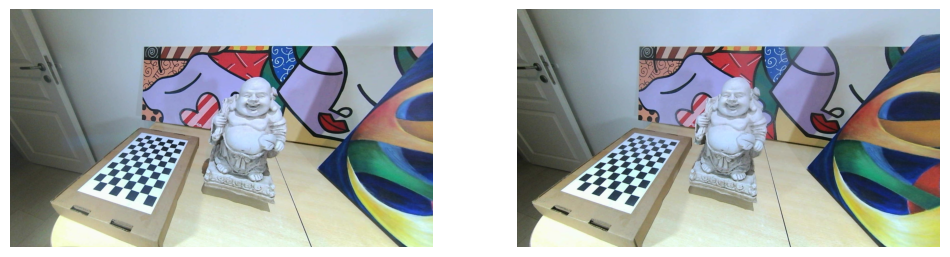

(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

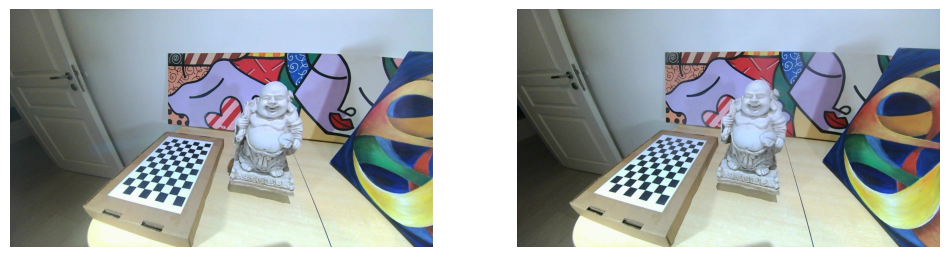

In [5]:
# Mapas de rectificación (izquierda y derecha)
left_image=cv2.imread("./datasets/stereo_budha_board/captures/left_4.jpg")
right_image=cv2.imread("./datasets/stereo_budha_board/captures/right_4.jpg")

left_image  = cv2.cvtColor(left_image,  cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)

left_map_x = stereo_maps["left_map_x"]
left_map_y = stereo_maps["left_map_y"]
right_map_x = stereo_maps["right_map_x"]
right_map_y = stereo_maps["right_map_y"]

left_rectified  = cv2.remap(left_image,  left_map_x,  left_map_y,  cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_rectified)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_rectified)
plt.axis("off")

plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(left_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(right_image)
plt.axis("off")

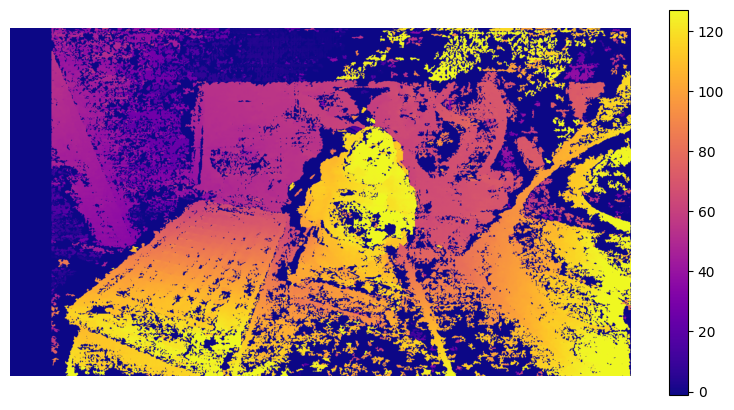

In [6]:

# Create StereoSGBM matcher
window_size = 5
min_disp = 0
num_disp = 16*8  # must be divisible by 16

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=window_size,
    P1=8*3*window_size**2,
    P2=32*3*window_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(left_rectified, right_rectified).astype(np.float32) / 16.0

# Optional: normalize for visualization
plt.figure(figsize=(10, 5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.axis('off')
plt.show()



In [7]:
# en esta celda se extraen los parametros del stereo_calibration.pkl para poder hacer lo de la tutorial 6

K1 = stereo_calibration['left_K']
K2 = stereo_calibration['right_K']

fx  = K1[0, 0]
fy  = K1[1, 1]
cx0 = K1[0, 2]
cy0 = K1[1, 2]

R = stereo_calibration['R']
T = stereo_calibration['T']
image_size = stereo_calibration['image_size']
dist1 = stereo_calibration['left_dist']
dist2 = stereo_calibration['right_dist']

R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    K1, dist1,
    K2, dist2,
    image_size, R, T,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
)

cx1 = P2[0, 2]


models\crestereo_combined_iter5_720x1280.onnx


d:\Workspace\udesa\tp2_reconstruccion_3d\.venv\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


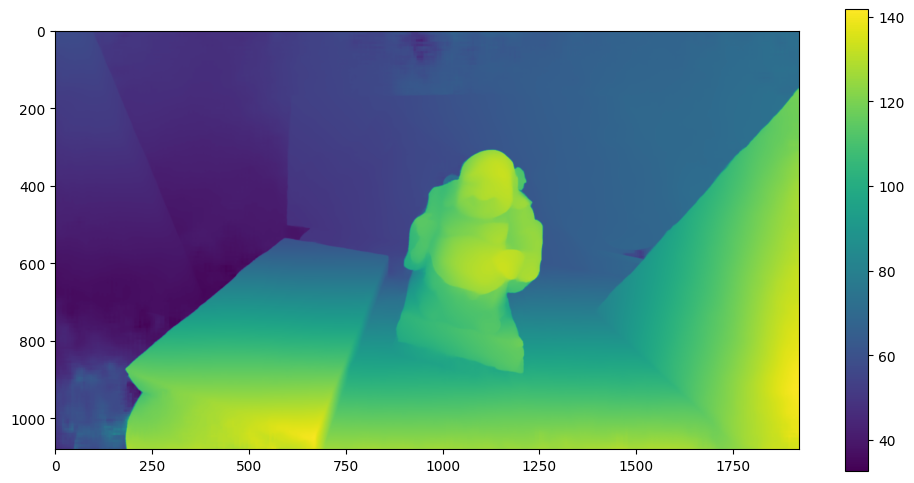

In [8]:
# copiado y pegado de la tutorial 6

from pathlib import Path
from disparity.method_cre_stereo import CREStereo
from disparity.method_opencv_bm import StereoBM, StereoSGBM
from disparity.methods import Calibration, InputPair, Config

w, h = left_image.shape[1], left_image.shape[0]

# fx = left_K[0][0]
# fy = left_K[1][1]
# cx0 = left_K[0][2]
# cy0 = left_K[1][2]

baseline = np.linalg.norm(T)



# Cre Stereo



calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})




models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)




#models_path = Path.home() / ".cache" / "stereodemo" / "models"
models_path = Path(models_path)
pair = InputPair(left_rectified, right_rectified, calibration)
# pair = InputPair(left_image, right_image, calibration)
config = Config(models_path=models_path)

# params = {
#    "Shape": "1280x720",
#    "Mode": "combined",
#    "Iterations": 20
#}
method = CREStereo(config)

#method.parameters["Shape"].set_value("640x480")
method.parameters["Shape"].set_value("1280x720")
# method.parameters["Iterations"].set_value("10")

#method.parameters.update(params)
# method = StereoBM(config)
# method = StereoSGBM(config)
# method = StereoBM(config)
disparity = method.compute_disparity(pair)





plt.figure(figsize=(12, 6))
plt.imshow(disparity.disparity_pixels)
plt.colorbar()
plt.show()